In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import glob as glob
import random
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K


2024-07-14 10:25:45.158267: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 10:25:45.158401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 10:25:45.316252: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_H,IMG_W=256,256


In [3]:
train_image_path="/kaggle/input/chest-segmentation-image/image"
train_mask_path="/kaggle/input/chest-segmentation-image/mask"
test_image_path="/kaggle/input/chest-segmentation-image/test_image"
test_mask_path="/kaggle/input/chest-segmentation-image/test_mask"

In [4]:
train_images=sorted(glob.glob(os.path.join(train_image_path,"*.png")))
train_masks=sorted(glob.glob(os.path.join(train_mask_path,"*.jpeg")))
test_images=sorted(glob.glob(os.path.join(test_image_path,"*.png")))
test_masks=sorted(glob.glob(os.path.join(test_mask_path,"*.jpeg")))

In [5]:
train_x,valid_x,train_y,valid_y=train_test_split(train_images,train_masks,test_size=0.1,random_state=32)

In [6]:
print("Length of Train Images: ",len(train_x))
print("Length of Test Images: ",len(test_images))
print("Length of Train Masks: ",len(train_y))
print("Length of Test Images: ",len(test_masks))
print("Length of Valid Images: ",len(valid_x))
print("Length of Train Masks: ",len(valid_y))

Length of Train Images:  4694
Length of Test Images:  640
Length of Train Masks:  4694
Length of Test Images:  640
Length of Valid Images:  522
Length of Train Masks:  522


In [7]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [8]:
create_dir("files")

In [9]:
def show_image_and_mask():
    plt.figure(figsize=(10,10))
    indices = random.sample(range(len(train_images)), 4)
    for i, idx in enumerate(indices):
        image = Image.open(train_images[idx])
        mask = Image.open(train_masks[idx])
        
        plt.subplot(len(indices), 2, 2*i+1)
        plt.imshow(image)
        plt.title(f"Image {idx}")
        plt.axis('off')
        
        plt.subplot(len(indices), 2, 2*i+2)
        plt.imshow(mask, cmap="gray")
        plt.title(f"Mask {idx}")
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig("/kaggle/working/files/Chest_Segmentation_Image_and_Mask.png")
    plt.show()



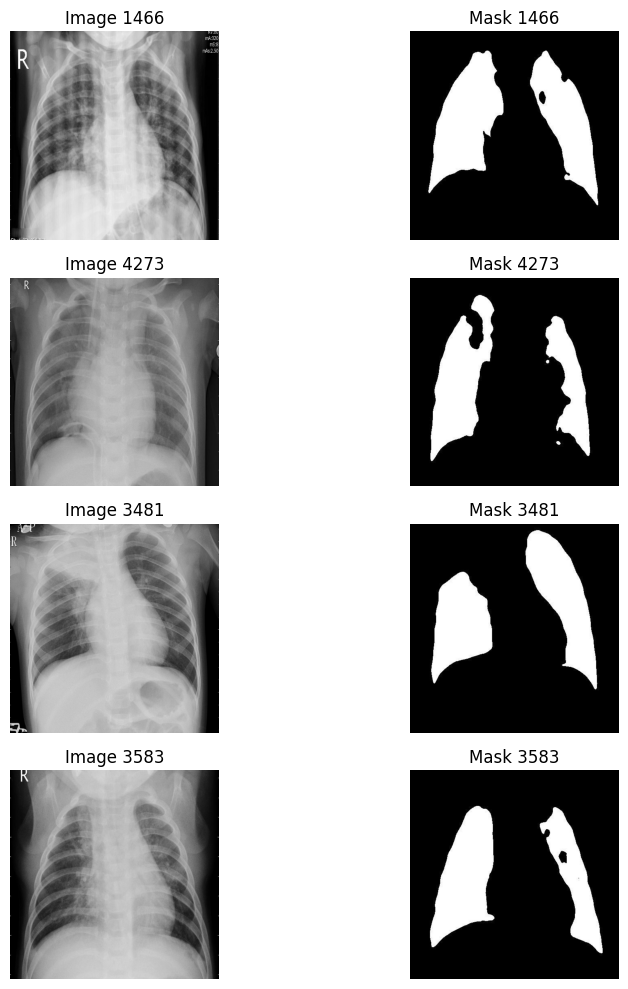

In [10]:
show_image_and_mask()

In [11]:
def read_image(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = image.resize((IMG_H, IMG_W))
    image = np.array(image, dtype=np.float32) / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    return image

def read_mask(mask_path):
    mask = Image.open(mask_path).convert('L')  # Convert to grayscale
    mask = mask.resize((IMG_H, IMG_W))
    mask = np.array(mask, dtype=np.float32) / 255.0  # Normalize to [0, 1]
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    return mask


In [12]:
np.random.seed(32)
tf.random.set_seed(32)

In [13]:
batch_size=32
lr=1e-3
num_epochs=30
model_path=os.path.join("files","chest_model.keras")
csv_path=os.path.join("files","log.csv")

In [14]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([IMG_H, IMG_W, 1])
    y.set_shape([IMG_H, IMG_W, 1])
    return x, y

        
def tf_dataset(X, y, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds


In [15]:
train_dataset=tf_dataset(train_x,train_y,batch=batch_size)
valid_dataset=tf_dataset(valid_x,valid_y,batch=batch_size)
test_dataset=tf_dataset(test_images,test_masks,batch=batch_size)


In [16]:
smooth = 1e-15

def dice_coef(y_true,y_pred):
    y_true_flat=tf.keras.layers.Flatten()(y_true)
    y_pred_flat=tf.keras.layers.Flatten()(y_pred)
    intersection=tf.reduce_sum(y_true*y_pred)
    return (2.*intersection+smooth)/(tf.reduce_sum(y_true)+tf.reduce_sum(y_pred)+smooth)

def dice_loss(y_true,y_pred):
    return 1.0-dice_coef(y_true,y_pred)

def iou(y_true, y_pred, smooth=1e-5):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    return K.mean(iou)


In [17]:
def unet_3_plus(input_size=(256,256,1),num_classes=1):
    def conv_block(input_tensor,num_filters):
        x=tf.keras.layers.Conv2D(num_filters,3,padding="same")(input_tensor)
        x=tf.keras.layers.BatchNormalization()(x)
        x=tf.keras.layers.Activation("relu")(x)
        x=tf.keras.layers.Conv2D(num_filters,3,padding="same")(x)
        x=tf.keras.layers.BatchNormalization()(x)
        x=tf.keras.layers.Activation("relu")(x)
        return x
    
    def encoder_block(input_tensor,num_filters):
        x=conv_block(input_tensor,num_filters)
        p=tf.keras.layers.MaxPooling2D((2,2))(x)
        return x,p
    
    def decoder_block(input_tensor,concat_tensor,num_filters):
        x =tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(input_tensor)
        x=tf.keras.layers.concatenate([x,concat_tensor])
        x=conv_block(x,num_filters)
        return x
        
        
    inputs=tf.keras.layers.Input(input_size)
    
    x1,p1=encoder_block(inputs,64)
    x2,p2=encoder_block(p1,128)
    x3,p3=encoder_block(p2,256)
    x4,p4=encoder_block(p3,512)
    
    b1=conv_block(p4,1024)
    
    d4=decoder_block(b1,x4,512)
    d3=decoder_block(d4,x3,256)
    d2=decoder_block(d3,x2,128)
    d1=decoder_block(d2,x1,64)
    
    outputs=tf.keras.layers.Conv2D(num_classes,(1,1),activation="sigmoid")(d1)
    
    model=tf.keras.models.Model(inputs,outputs)
    
    return model

In [18]:
model=unet_3_plus(input_size=(256,256,1),num_classes=1)
# model.summary()

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=["accuracy", iou, dice_coef],
              loss=dice_loss)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.CSVLogger(csv_path),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
]



In [20]:
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=callbacks
)



Epoch 1/30


2024-07-14 10:27:34.222085: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=1,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-14 10:27:34.246278: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.024368138s
Trying algorithm eng36{k2=1,k3=0} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,256,256]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0

146/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.8505 - dice_coef: 0.7196 - iou: 0.6251 - loss: 0.2804

2024-07-14 10:37:00.159747: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,64,256,256]{3,2,1,0}, f32[22,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-14 10:37:02.129418: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.969766956s
Trying algorithm eng0{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,64,256,256]{3,2,1,0}, f32[22,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-14 10:37:05.429877: E external/

147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8509 - dice_coef: 0.7203 - iou: 0.6258 - loss: 0.2797
Epoch 1: val_loss improved from inf to 0.98342, saving model to files/chest_model.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 795s 3s/step - accuracy: 0.8512 - dice_coef: 0.7210 - iou: 0.6266 - loss: 0.2790 - val_accuracy: 0.7959 - val_dice_coef: 0.0166 - val_iou: 0.0019 - val_loss: 0.9834 - learning_rate: 0.0010
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9304 - dice_coef: 0.9157 - iou: 0.8227 - loss: 0.0843
Epoch 2: val_loss did not improve from 0.98342
147/147 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.9304 - dice_coef: 0.9157 - iou: 0.8227 - loss: 0.0843 - val_accuracy: 0.7961 - val_dice_coef: 0.0101 - val_iou: 0.0031 - val_loss: 0.9898 - learning_rate: 0.0010
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9333 - dice_coef: 0.9313 - iou: 0.8432 - loss: 0.0687
Epoch 3: val_loss improved from 0.98342 to 0.56900, saving model to files/chest_mod

In [21]:
print(f"The testing loss is : {round(history.history['val_loss'][-1],2)}\n")
print(f"The testing accuracy is : {round(history.history['val_accuracy'][-1],2)}%\n")
print(f"The testing dice coef is : {round(history.history['val_dice_coef'][-1],2)}\n")
print(f"The testing iou is : {round(history.history['val_iou'][-1],2)}\n")

The testing loss is : 0.05

The testing accuracy is : 0.94%

The testing dice coef is : 0.95

The testing iou is : 0.87



In [22]:
print(f"The  loss is : {round(history.history['loss'][-1],2)}\n")
print(f"The  accuracy is : {round(history.history['accuracy'][-1],2)}%\n")
print(f"The  dice coef is : {round(history.history['dice_coef'][-1],2)}\n")
print(f"The  iou is : {round(history.history['iou'][-1],2)}\n")

The  loss is : 0.04

The  accuracy is : 0.94%

The  dice coef is : 0.96

The  iou is : 0.91



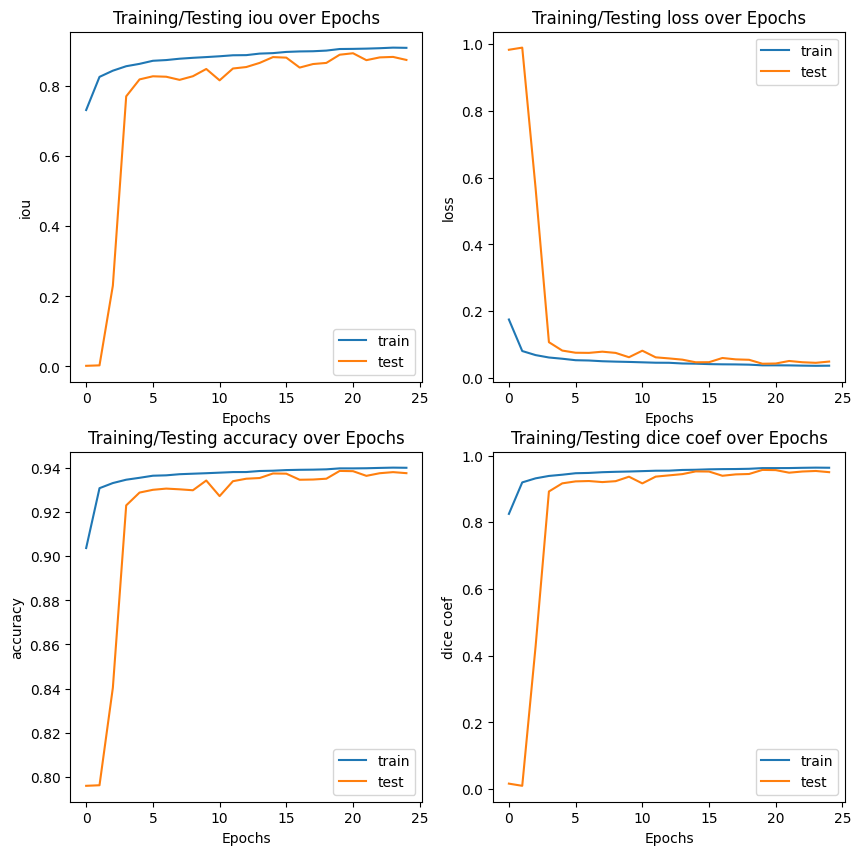

<Figure size 640x480 with 0 Axes>

In [23]:
figure,axes=plt.subplots(2,2,figsize=(10,10))

axes[0][0].plot(history.history["iou"],label="train")
axes[0][0].plot(history.history["val_iou"],label="test")
axes[0,0].set_title('Training/Testing iou over Epochs')
axes[0,0].set_xlabel('Epochs')
axes[0,0].set_ylabel('iou')
axes[0,0].legend()


axes[0][1].plot(history.history["loss"],label="train")
axes[0][1].plot(history.history["val_loss"],label="test")
axes[0,1].set_title('Training/Testing loss over Epochs')
axes[0,1].set_xlabel('Epochs')
axes[0,1].set_ylabel('loss')
axes[0,1].legend()

axes[1][0].plot(history.history["accuracy"],label="train")
axes[1][0].plot(history.history["val_accuracy"],label="test")
axes[1,0].set_title('Training/Testing accuracy over Epochs')
axes[1,0].set_xlabel('Epochs')
axes[1,0].set_ylabel('accuracy')
axes[1,0].legend()


axes[1][1].plot(history.history["dice_coef"],label="train")
axes[1][1].plot(history.history["val_dice_coef"],label="test")
axes[1,1].set_title('Training/Testing dice coef over Epochs')
axes[1,1].set_xlabel('Epochs')
axes[1,1].set_ylabel('dice coef')
axes[1,1].legend()

plt.show()
plt.savefig("/kaggle/working/files/Chest_Segmentated_train.jpg", bbox_inches='tight')

In [24]:
x_testsample , y_testsample = next(iter(test_dataset))

y_pred=model.predict(x_testsample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [25]:
def draw(test_images, test_masks, y_preds, save_path=None):
    plt.figure(figsize=(20, 10))
    index = 0
    n = np.random.randint(y_preds.shape[0])
    for i in range(18):
        plt.subplot(3, 6, (i + 1))
        if index == 0:
            plt.imshow(test_images[n])
            plt.title('Original Image')
            index = 1
            plt.axis('off')
        elif index == 1:
            plt.imshow(test_masks[n])
            plt.imshow(test_masks[n], alpha=0.2, cmap='jet')
            plt.title('Original Mask')
            index = 2
            plt.axis('off')
        elif index == 2: 
            plt.imshow(test_masks[n])
            plt.imshow(y_preds[n], alpha=0.2, cmap='jet')
            plt.title('Predict Mask')
            index = 0
            n = np.random.randint(y_preds.shape[0])
            plt.axis('off')
        
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        
    plt.show()

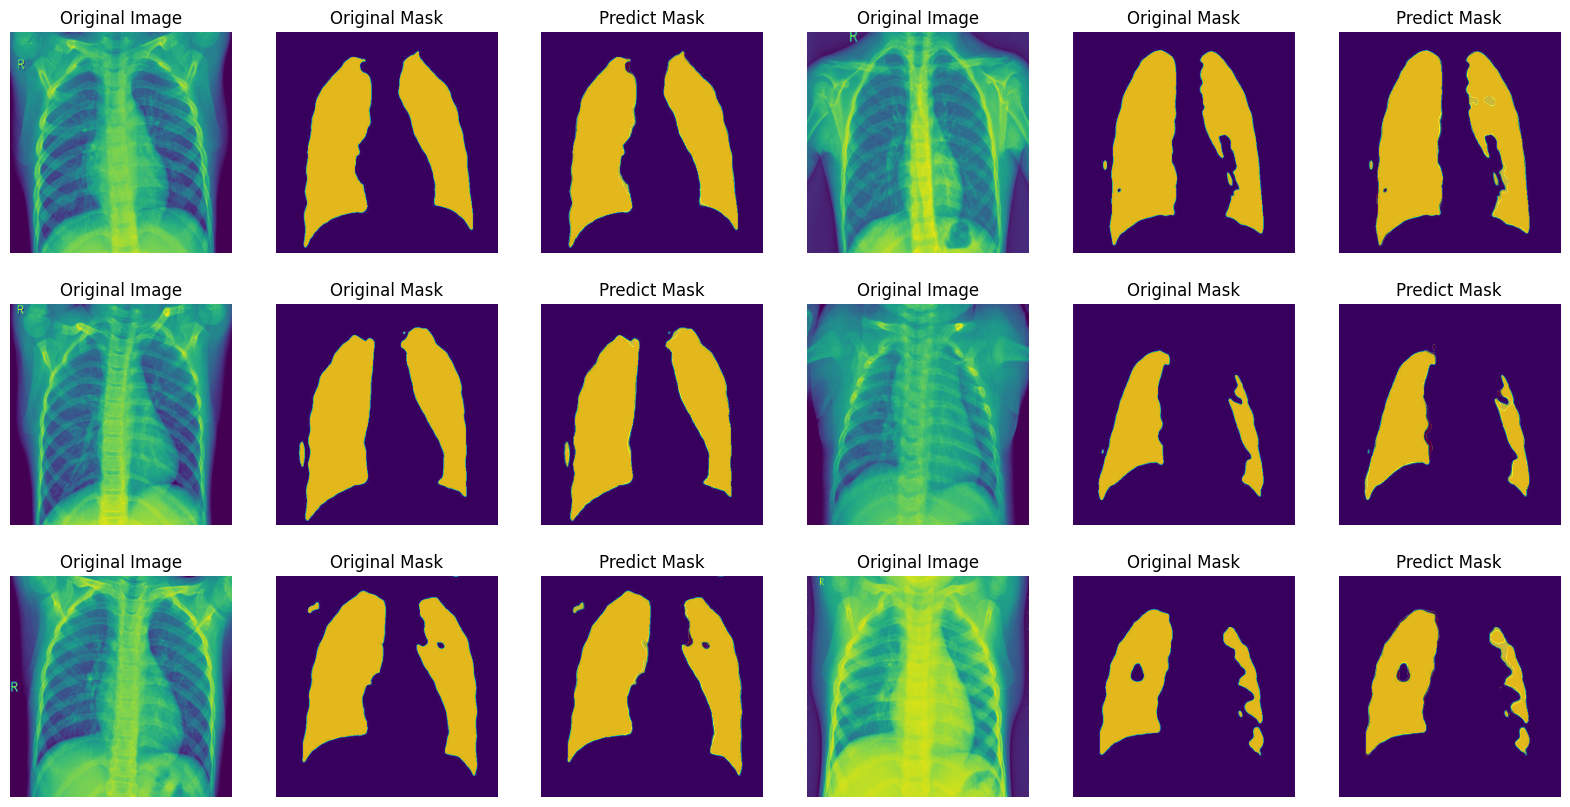

In [26]:
draw(x_testsample, y_testsample , y_pred,"/kaggle/working/files/chest_segmentated_mask_image.jpg")

In [27]:
model.save("/kaggle/working/chest_segmentated_model.h5")
